In [1]:
import torch
import os
from matplotlib import pyplot as plt

In [2]:
root_path = "/home/yigit/projects/mbcnp/outputs/sine/"

cnp_tls, cnp_ves, wta_tls, wta_ves = {}, {}, {}, {}

for suffix in os.listdir(root_path):
    if suffix.startswith('1692'):
        d = os.path.join(root_path, suffix)
        if os.path.isdir(d):
            tl_code, ve_code = 'training_loss', 'validation_error'
            cnp_tl_path, cnp_ve_path = f'{d}/cnp_{tl_code}.pt', f'{d}/cnp_{ve_code}.pt'
            wta_tl_path, wta_ve_path = f'{d}/wta_{tl_code}.pt', f'{d}/wta_{ve_code}.pt'

            cnp_tl, cnp_ve = torch.load(cnp_tl_path, map_location=torch.device('cpu')), torch.load(cnp_ve_path, map_location=torch.device('cpu'))
            wta_tl, wta_ve = torch.load(wta_tl_path, map_location=torch.device('cpu')), torch.load(wta_ve_path, map_location=torch.device('cpu'))

            tl_size, ve_size = min(cnp_tl.shape[0], wta_tl.shape[0]), min(cnp_ve.shape[0], wta_ve.shape[0])
            if tl_size < 500_000:
                continue

            cnp_tl, cnp_ve = cnp_tl[:tl_size], cnp_ve[:ve_size]
            wta_tl, wta_ve = wta_tl[:tl_size], wta_ve[:ve_size]

            cnp_tls.update({suffix:cnp_tl})
            cnp_ves.update({suffix:cnp_ve})
            wta_tls.update({suffix:wta_tl})
            wta_ves.update({suffix:wta_ve})


In [3]:
def mean_filter(x: torch.Tensor, window_size):
    return torch.nn.functional.avg_pool1d(x.unsqueeze(0), window_size, stride=1).squeeze(0)


def compare_and_plot(t0, t1, window_size=50000, step=5000, index=0, is_tl=True):
    # Comparing training losses
    t0_filtered, t1_filtered = mean_filter(t0, window_size), mean_filter(t1, window_size)

    tl_size = t0_filtered.shape[0]
    idx = torch.arange(start=0, end=tl_size, step=step)

    x = torch.arange(idx.shape[0])
    y1 = t0_filtered[idx]
    y2 = t1_filtered[idx]

    if is_tl:
        title = 'Training Loss'
        xlabel = f'Epoch x {step}'
        ylabel = 'NLL Loss'
        suffix = 'tl'
    else:
        title = 'Validation Error'
        ylabel = 'MSE'
        suffix = 've'
        xlabel = 'Epoch' if step == 1 else f'Epoch x {step}'

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(x, y1, 'b-', label='CNP')
    plt.plot(x, y2, 'r-', label='CNEP-Select')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    plt.savefig(f'{root_path}comparison/{index}_{suffix}.png')
    plt.close()

In [4]:
from tqdm import tqdm

for key in tqdm(cnp_tls):
    compare_and_plot(cnp_tls[key], wta_tls[key], index=key, is_tl=True)

    # Comparing validation errors
    window_size=5
    step=1
    compare_and_plot(cnp_ves[key], wta_ves[key], window_size=window_size, step=step, index=key, is_tl=False)


100%|██████████| 15/15 [03:07<00:00, 12.53s/it]


In [5]:
cnp_tl_mean, cnp_ve_mean = cnp_tl.mean(dim=0), cnp_ve.mean(dim=0)
cnp_tl_std, cnp_ve_std = cnp_tl.std(dim=0), cnp_ve.std(dim=0)
wta_tl_mean, wta_ve_mean = wta_tl.mean(dim=0), wta_ve.mean(dim=0)
wta_tl_std, wta_ve_std = wta_tl.std(dim=0), wta_ve.std(dim=0)

In [6]:

# plt.subplot(1, 2, 1)
# plt.plot(, cnp_tl[idx], '-', label='CNP')
# # plt.plot(wta_tl)
# plt.xlabel(f'Epoch x {step}')
# plt.ylabel('Loss')
# plt.title('CNP Training Loss')

# plt.subplot(1, 2, 2)
# plt.plot(torch.arange(idx.shape[0]), wta_tl[idx], '-', label='WTA')
# # plt.plot(wta_tl)
# plt.xlabel(f'Epoch x {step}')
# plt.ylabel('Loss')
# plt.title('WTA Training Loss')

# plt.tight_layout()
# plt.show()


<Figure size 800x600 with 0 Axes>

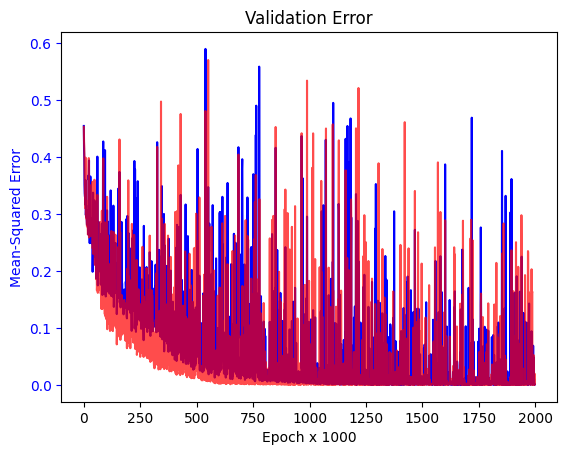

In [7]:
step=1
idx = torch.arange(start=1, end=ve_size, step=step)

x = torch.arange(idx.shape[0])
y1 = cnp_ve[idx]
y2 = wta_ve[idx]

plt.figure(figsize=(8, 6))

fig, ax1 = plt.subplots()
ax1.title.set_text('Validation Error')

ax1.plot(x, y1, 'b-', label='CNP')
ax1.plot(x, y2, 'r-', label='WTA', alpha=0.7)
ax1.set_xlabel(f'Epoch x 1000')
ax1.set_ylabel('Mean-Squared Error', color='b')
ax1.tick_params('y', colors='b')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()

# Display the plot
plt.show()